In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import warnings
from dataclasses import dataclass
from enum import StrEnum
import random

from torch.optim import AdamW

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

from patientInfo import *

from transformers import get_cosine_schedule_with_warmup

from sklearn.model_selection import KFold

import pickle

In [2]:

DEBUG = False
# DATA_DIR = "./data/"
MODEL_NAME = "tf_efficientnet_b0.ns_jft_in1k" if DEBUG else "tf_efficientnet_b5.ns_jft_in1k"
DEVICE = "cuda:0"
MODEL_DIR = "./models/axial_t2"

EPOCHS = 15

HEIGHT = 512
WIDTH = 512

# Network params
N_CLASSES = 2
HIDDEN_DIM = 768
LOCATION_DIM = 4


SEED = 8620
N_WORKERS=6

GRAD_ACC = 1
TGT_BATCH_SIZE = 16
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
EARLY_STOPPING_EPOCH = 3
OUTPUT_DIR = "models/sagittial_t2_stir"


TEST_BATCH_SIZE = 1

N_FOLDS = 5

LR = 2e-4 * TGT_BATCH_SIZE / 32
AUG = True

In [3]:

train_df = pd.read_csv("./data/train.csv")
train_label_coordinates_df = pd.read_csv("./data/train_label_coordinates.csv")
train_series_descriptions_df = pd.read_csv("./data/train_series_descriptions.csv")

In [4]:

def vertical_flip(img, coord):
    new_coord = coord.copy()
    img = cv2.flip(img, 0)  # 0 for vertical flip
    new_coord[:, 1] = img.shape[1] - new_coord[:, 1]  # Adjusting the y-coordinates for vertical flip
    return img, new_coord

def horizontal_flip(img, coord):
    new_coord = coord.copy()
    img = cv2.flip(img, 1)  # Corrected to 1 for horizontal flip
    new_coord[:, 0] = img.shape[0] - new_coord[:, 0]  # Adjusting the x-coordinates for horizontal flip
    return img, new_coord

def resize(img, coord, height, width):
    print(f"resizing: {img.shape}")
    new_coord = coord.copy()

    orig_height, orig_width = img.shape

    img = cv2.resize(img, (height, width),interpolation=cv2.INTER_CUBIC)
    new_coord = new_coord * np.array([ height / orig_height, width / orig_width ])
    return img, new_coord

In [5]:

class RSNA24Dataset(Dataset):
    def __init__(self, patient_ids, transformations=[], height=HEIGHT, width=WIDTH, phase="train", positive_negative_ratio=0.4, positive_augment_prob=0.25, negative_augment_prob=0.15):
        self.patient_ids = patient_ids
        self.transformations = transformations
        self.positive_negative_ratio = positive_negative_ratio
        self.positive_augment_prob = positive_augment_prob
        self.negative_augment_prob = negative_augment_prob
        self.phase = phase
        self.height = height
        self.width = width
    
    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        
        patient_id = self.patient_ids[idx]
        patient_info = PatientInfo.from_df(self.patient_ids[idx], train_df, train_series_descriptions_df, train_label_coordinates_df, "./data/train_images")
        # imgs = 

        if self.phase == "train":

            y_class = np.zeros(2)
            y_loc = np.zeros((2,2))

            if random.random() <= self.positive_negative_ratio:
                imgs = [img for img in patient_info.get_scans(Scan.AxialT2) if img.has_label()]
                has_sampled_postive_label = True
            else:
                imgs = [img for img in patient_info.get_scans(Scan.AxialT2) if not img.has_label()]
                has_sampled_postive_label = False

            
            img = random.choice(imgs) if len(imgs) != 0 else random.choice(patient_info.get_scans(Scan.AxialT2))
            x = img.dicom.pixel_array.astype(np.float32)
    
            for label in img.labels:

                if label.location.condition == Condition.LSS:
                    y_class[0] = 1
                    y_loc[0] = np.array([label.x, label.y])
                elif label.location.condition == Condition.RSS:
                    y_class[1] = 1
                    y_loc[1] = np.array([label.x, label.y])
                else:
                    raise ValueError(f"Unexpected condition in the image label: {img}, condition={label.location.condition}")

            if x.shape != (self.height, self.width):
                x,y_loc = resize(x, y_loc, height=self.height, width=self.width)
                
            aug_prob = self.positive_augment_prob if has_sampled_postive_label else self.negative_augment_prob
            x,y_loc = self.transform(x, y_class, y_loc,aug_prob)
    
            x = x / 255
            x = np.expand_dims(x, 0)
    
            return x, (y_class,y_loc)
            
        else:
            
            imgs = patient_info.get_scans(Scan.AxialT2)
            num_imgs = len(imgs)
            xs = np.zeros((num_imgs, self.height, self.width))
            
            y_classes = np.zeros((num_imgs, 2))
            y_locs = np.zeros((num_imgs, 2, 2))

            for idx,img in enumerate(imgs):
                x = img.dicom.pixel_array.astype(np.float32)
                # xs[idx] = cv2.resize(x, (self.height, self.width),interpolation=cv2.INTER_CUBIC)
            
                for label in img.labels:
    
                    if label.location.condition == Condition.LSS:
                        y_classes[idx, 0] = 1
                        y_locs[idx, 0] = np.array([label.x, label.y])
                    elif label.location.condition == Condition.RSS:
                        y_classes[idx, 1] = 1
                        y_locs[idx, 1] = np.array([label.x, label.y])
                    else:
                        raise ValueError(f"Unexpected condition in the image label: {img}, condition={label.location.condition}")
                        
                if x.shape != (self.height, self.width):
                    x,y_loc = resize(x, y_locs[idx], height=self.height, width=self.width)
                    y_locs[idx] = y_loc
                xs[idx] = x
                        
            xs = xs / 255
            xs = np.expand_dims(xs, 1)
            return xs, (y_classes, y_locs)
        

    def transform(self, x, y_class, y_loc, aug_prob):
        for transformation in self.transformations:
            if random.random() <= aug_prob:
                x,y_loc = transformation(x,y_loc)
                y_loc = np.expand_dims(y_class, 1) * y_loc
                    
        return x, y_loc
            

In [6]:

class AvgPool(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,x):

        r = list(x.shape)[:-2]
        r.append(-1)
        x = x.reshape(tuple(r)).mean(dim=-1)
        
        return x

class RSNA24Model(nn.Module):
    def __init__(self, model_name, n_classes=N_CLASSES, location_dim=LOCATION_DIM, hidden_dim=HIDDEN_DIM, pretrained=True, features_only=True):
        super().__init__()
        
        self.img_features  = 512
        self.img_features_dim = 2048
        self.hidden_dim = hidden_dim
        self.n_classes = n_classes
        self.location_dim = location_dim

        self.initial_conv = nn.Conv2d(1,3, (3,3), stride=(1,1), padding=(1,1))
        self.feature_extractor =  timm.create_model( model_name , pretrained=pretrained , features_only=features_only, out_indices=[-1] )

        self.predictors = nn.Sequential(
            nn.Conv2d(self.img_features, self.img_features, (3,3), stride=(1,1), padding=(1,1)),
            nn.SiLU(),
            nn.Conv2d(self.img_features, self.img_features_dim, (1,1), stride=(1,1), bias=False),
            nn.BatchNorm2d(self.img_features_dim),
            AvgPool(),
            nn.Linear(self.img_features_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.n_classes)
        )

        self.location_predictor = nn.Sequential(
            nn.Conv2d(self.img_features, self.img_features, (3,3), stride=(1,1), padding=(1,1)),
            nn.SiLU(),
            nn.Conv2d(self.img_features, self.img_features, (3,3), stride=(1,1), padding=(1,1)),
            nn.SiLU(),
            nn.Conv2d(self.img_features, self.img_features_dim, (1,1), stride=(1,1), bias=False),
            nn.BatchNorm2d(self.img_features_dim),
            AvgPool(),
            nn.Linear(self.img_features_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.location_dim)
        )

    
    def forward(self, x, freeze_conv=False):
        x = self.initial_conv(x)

        if freeze_conv:
            with torch.no_grad():
                x = self.feature_extractor(x)[0]
        else:
            x = self.feature_extractor(x)[0]
            
        class_preds = self.predictors(x)
        location_preds = self.location_predictor(x)
        return class_preds, location_preds

In [7]:

bce = nn.BCEWithLogitsLoss()
def criterion(y_class, y_loc, pred_class, pred_loc, alpha=0.01):
    
    class_loss = bce(pred_class, y_class)
    
    loc_loss = (((pred_loc - y_loc) ** 2).sum(-1).sqrt() * y_class).mean(-1).mean()

    return (class_loss + alpha * loc_loss), {"class_loss": class_loss, "loc_loss": loc_loss}


def train(model,dataloader, criterion, optimizer, scheduler=None, freeze_conv=False):
    
    model.train()
    optimizer.zero_grad()
    training_loss = []
    
    for idx, (x, y) in enumerate(pbar := tqdm(dataloader)):
        
        x, y_class, y_loc = x.to(DEVICE), y[0].to(DEVICE), y[1].to(DEVICE)
        
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            pred_class, pred_loc = model(x, freeze_conv=freeze_conv)
            pred_loc = pred_loc.reshape(-1,2,2)
            loss, _ = criterion(y_class, y_loc, pred_class, pred_loc)
            loss = loss / GRAD_ACC
            
        loss.backward()
        norm = nn.utils.clip_grad_norm(model.parameters(), 1.0)

        training_loss.append(loss.item() * GRAD_ACC)

        if (idx + 1) % GRAD_ACC == 0:
            optimizer.step()
            optimizer.zero_grad()
            if scheduler is not None:
                scheduler.step()


        pbar.set_description(f"loss: {loss.item() * GRAD_ACC:.6f}, | norm: {norm:.4f}| training_loss: {np.mean(training_loss):.6f}")
        
    
    return np.mean(training_loss)

def validation(model, data_loader, criterion):
    
        model.eval()
    
        val_loss = []
        loc_loss = []
        class_loss = []

        with torch.no_grad():
    
            for idx, (x, y) in enumerate(pbar := tqdm(data_loader)):
                
                x, y_class, y_loc = x.to(DEVICE).squeeze(0).float(), y[0].to(DEVICE).squeeze(0), y[1].to(DEVICE).squeeze(0)
                # print(x.shape, y_class.shape, y_loc.shape)

                with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                    pred_class, pred_loc = model(x)
                    
                    # print(pred_class.shape, pred_loc.shape)
                    
                    pred_loc = pred_loc.reshape(-1,2,2)
                    loss, per_cat_loss = criterion(y_class, y_loc, pred_class, pred_loc)

                val_loss.append(loss.item())
                loc_loss.append(per_cat_loss["loc_loss"].item())
                class_loss.append(per_cat_loss["class_loss"].item())
                
    
                pbar.set_description(f"current loss: {loss.item():.6f}, validation_loss: {np.mean(val_loss):.6f}, loc_loss: {np.mean(loc_loss)}, class_loss: {np.mean(class_loss)}")

        return np.mean(val_loss), np.mean(loc_loss), np.mean(class_loss)
    

In [8]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

In [9]:

for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(train_df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    print(len(trn_idx), len(val_idx))
    
    df_train = train_df.iloc[trn_idx]
    df_valid = train_df.iloc[val_idx]
    
    train_ds = RSNA24Dataset(df_train["study_id"].unique(), phase='train', transformations=[vertical_flip, horizontal_flip])
    train_dl = DataLoader(
                train_ds,
                batch_size=BATCH_SIZE,
                shuffle=True,
                pin_memory=True,
                drop_last=True,
                num_workers=N_WORKERS
                )

    valid_ds = RSNA24Dataset(df_valid["study_id"].unique(), phase='valid', transformations=[])
    valid_dl = DataLoader(
                valid_ds,
                batch_size=1,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )
    
    model = RSNA24Model(MODEL_NAME).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LR)

    
    warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
    num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
    num_cycles = 0.475
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                num_warmup_steps=warmup_steps,
                                                num_training_steps=num_total_steps,
                                                num_cycles=num_cycles)

    best_val_loss   = 1.47
    best_loc_loss   = 47.32
    best_class_loss = 1.00
    early_stop_counter = 0

    for epoch in range(1, EPOCHS + 1):
        print(f"EPOCH: {epoch}")
        _ = train(model, train_dl, criterion, optimizer, scheduler, freeze_conv=False)
        val_loss, loc_loss, class_loss = validation(model, valid_dl, criterion)

        print(f"val_loss: {val_loss:.4f} | loc_loss: {loc_loss:.4f} | class_loss: {class_loss:.4f}")

        if loc_loss < best_loc_loss:
            early_stop_counter = 0
            print(f"updating best_loc_loss from {best_loc_loss} to {loc_loss}")
            
            best_val_loss = val_loss
            best_loc_loss = loc_loss
            best_class_loss = class_loss

            print(f"updated losses: {best_val_loss=}, {best_loc_loss=}, {best_class_loss=}")

            print("Saving model....")
            fname = f'{OUTPUT_DIR}/best_loc_model_fold-{fold}.pt'
            torch.save(model.state_dict(), fname)
            
        else:
            early_stop_counter += 1
            print(f"{EARLY_STOPPING_EPOCH - early_stop_counter} more epochs to train until early stopping")

        if early_stop_counter == EARLY_STOPPING_EPOCH:
            break
        

##############################
start fold0
##############################
1580 395


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


EPOCH: 1


  0%|                                                                                                                                                                                                                  | 0/98 [00:00<?, ?it/s]/tmp/ipykernel_9590/3253694727.py:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  norm = nn.utils.clip_grad_norm(model.parameters(), 1.0)
loss: 2.089654, | norm: 1.9143| training_loss: 1.677555: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.65it/s]
current loss: 0.621993, validation_loss: 0.913716, loc_loss: 49.830447427203346, class_loss: 0.4154117196918746: 100%|██████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:44<00:00,  8.87it/s]


val_loss: 0.9137 | loc_loss: 49.8304 | class_loss: 0.4154
2 more epochs to train until early stopping
EPOCH: 2


loss: 0.483038, | norm: 6.9974| training_loss: 1.149788: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.74it/s]
current loss: 0.485952, validation_loss: 0.492736, loc_loss: 20.610106878281137, class_loss: 0.2866346690896846: 100%|██████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:43<00:00,  9.16it/s]


val_loss: 0.4927 | loc_loss: 20.6101 | class_loss: 0.2866
updating best_loc_loss from 47.32 to 20.610106878281137
updated losses: best_val_loss=0.49273573787249597, best_loc_loss=20.610106878281137, best_class_loss=0.2866346690896846
Saving model....
EPOCH: 3


loss: 0.759231, | norm: 3.9355| training_loss: 0.629323: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.73it/s]
current loss: 0.289521, validation_loss: 0.334132, loc_loss: 6.018995480025124, class_loss: 0.27394192343680024: 100%|██████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:43<00:00,  9.16it/s]


val_loss: 0.3341 | loc_loss: 6.0190 | class_loss: 0.2739
updating best_loc_loss from 20.610106878281137 to 6.018995480025124
updated losses: best_val_loss=0.3341318782370515, best_loc_loss=6.018995480025124, best_class_loss=0.27394192343680024
Saving model....
EPOCH: 4


loss: 0.360578, | norm: 1.1914| training_loss: 0.544529: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:17<00:00,  5.72it/s]
current loss: 0.314320, validation_loss: 0.308222, loc_loss: 5.565635081213799, class_loss: 0.2525654629245823: 100%|███████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:43<00:00,  9.16it/s]


val_loss: 0.3082 | loc_loss: 5.5656 | class_loss: 0.2526
updating best_loc_loss from 6.018995480025124 to 5.565635081213799
updated losses: best_val_loss=0.3082218137367203, best_loc_loss=5.565635081213799, best_class_loss=0.2525654629245823
Saving model....
EPOCH: 5


loss: 0.577967, | norm: 30.2740| training_loss: 0.541812: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.82it/s]
current loss: 0.300879, validation_loss: 0.337231, loc_loss: 7.210052026434796, class_loss: 0.26513043361409355: 100%|██████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:43<00:00,  9.15it/s]


val_loss: 0.3372 | loc_loss: 7.2101 | class_loss: 0.2651
2 more epochs to train until early stopping
EPOCH: 6


loss: 0.557658, | norm: 1.9173| training_loss: 0.524399: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.78it/s]
current loss: 0.235301, validation_loss: 0.295945, loc_loss: 4.6993265619881015, class_loss: 0.2489522057309385: 100%|██████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:43<00:00,  9.14it/s]


val_loss: 0.2959 | loc_loss: 4.6993 | class_loss: 0.2490
updating best_loc_loss from 5.565635081213799 to 4.6993265619881015
updated losses: best_val_loss=0.2959454713508195, best_loc_loss=4.6993265619881015, best_class_loss=0.2489522057309385
Saving model....
EPOCH: 7


loss: 0.421564, | norm: 3.9705| training_loss: 0.509248: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.78it/s]
current loss: 0.271101, validation_loss: 0.290142, loc_loss: 4.349213896819737, class_loss: 0.2466502350791268: 100%|███████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:43<00:00,  9.15it/s]


val_loss: 0.2901 | loc_loss: 4.3492 | class_loss: 0.2467
updating best_loc_loss from 4.6993265619881015 to 4.349213896819737
updated losses: best_val_loss=0.2901423740473242, best_loc_loss=4.349213896819737, best_class_loss=0.2466502350791268
Saving model....
EPOCH: 8


loss: 0.510786, | norm: 8.4718| training_loss: 0.522157: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.78it/s]
current loss: 0.283838, validation_loss: 0.286161, loc_loss: 4.796627024283415, class_loss: 0.23819462947014172: 100%|██████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:43<00:00,  9.16it/s]


val_loss: 0.2862 | loc_loss: 4.7966 | class_loss: 0.2382
2 more epochs to train until early stopping
EPOCH: 9


loss: 0.526697, | norm: 2.1171| training_loss: 0.467937: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:16<00:00,  5.80it/s]
current loss: 0.396035, validation_loss: 0.293321, loc_loss: 4.672005025005849, class_loss: 0.24660111718761693:  70%|███████████████████████████████████████████████████████████▊                          | 275/395 [00:30<00:13,  9.12it/s]


KeyboardInterrupt: 

In [10]:
val_idx

array([   5,    7,    8,   12,   18,   22,   24,   31,   39,   40,   43,
         45,   48,   57,   58,   60,   68,   72,   74,   81,   87,   88,
         94,   97,  102,  108,  111,  112,  114,  120,  128,  133,  162,
        165,  167,  169,  183,  189,  191,  197,  204,  207,  209,  216,
        218,  233,  234,  241,  253,  257,  262,  267,  270,  275,  280,
        288,  289,  291,  297,  299,  301,  302,  304,  311,  317,  327,
        330,  331,  334,  336,  337,  339,  341,  345,  362,  364,  371,
        380,  385,  387,  388,  395,  398,  407,  410,  411,  433,  439,
        441,  447,  449,  451,  453,  457,  459,  465,  473,  479,  486,
        489,  493,  498,  507,  514,  517,  518,  520,  528,  534,  536,
        552,  557,  558,  563,  571,  573,  576,  578,  581,  582,  583,
        584,  587,  591,  593,  594,  602,  604,  606,  610,  619,  627,
        628,  642,  644,  649,  650,  653,  662,  666,  667,  671,  682,
        689,  693,  694,  695,  700,  711,  716,  7

In [9]:
ds = RSNA24Dataset(train_df["study_id"])

In [11]:
x,(y_class, y_loc) = ds[7]

print(y_class, y_loc)

# with torch.no_grad():
#     t_x = torch.from_numpy(x).unsqueeze(0).to(DEVICE)
#     pred_class, pred_loc = model(t_x)
#     print(pred_class.sigmoid(), pred_loc)
#     pred_loc = pred_loc.reshape(-1,2,2).cpu().squeeze().numpy()
#     pred_class = pred_class.cpu().squeeze().numpy()

x = x.squeeze()


resizing: (640, 640)
[1. 1.] [[275.65250965 262.91891892]
 [221.11150442 258.03893805]]


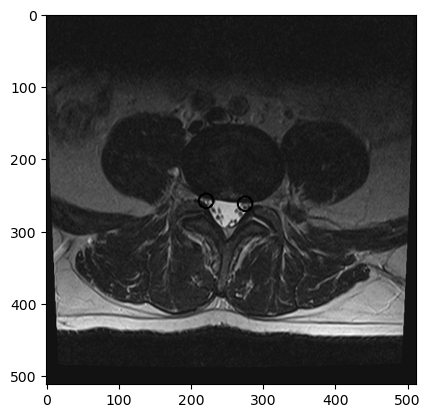

In [12]:
x = cv2.normalize(x, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
for i in range(2):

    # c = (int(pred_loc[i][0]), int(pred_loc[i][1]))
    # x = cv2.circle(x.copy(), c, 10, (255,0,0), 2)
    
    c = (int(y_loc[i][0]), int(y_loc[i][1]))
    x = cv2.circle(x.copy(), c, 10, (0,255,0), 2)

plt.imshow(x, cmap="gray")
plt.show()